In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

data = pd.read_csv('/Users/aryasalian/MyProjects-github/JPM Quantitative Research Course Projects/Task 1/Nat_Gas OG.csv', names = ['Dates','Prices'], header = 0, parse_dates=['Dates'], index_col= 'Dates')
data.head()

/Users/aryasalian/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/var/folders/hb/clzbwtq527b2g9qfk2dhk1yr0000gn/T/ipykernel_42357/3458055480.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv('/Users/aryasalian/MyProjects-github/JPM Quantitative Research Course Projects/Task 1/Nat_Gas OG.csv', names = ['Dates','Prices'], header = 0, parse_dates=['Dates'], index_col= 'Dates')


,Prices
Dates,
2020-10-31,10.1
2020-11-30,10.3
2020-12-31,11.0
2021-01-31,10.9
2021-02-28,10.9


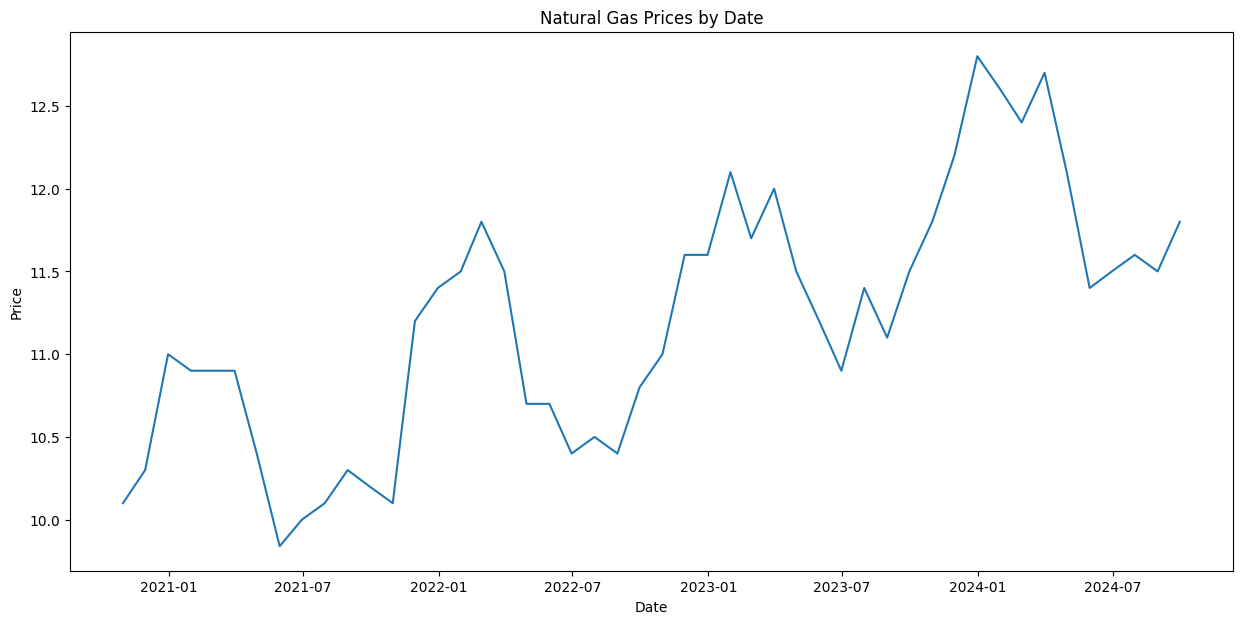

In [2]:
plt.figure(figsize=(15,7))
plt.title("Natural Gas Prices by Date")
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(data)
plt.show()

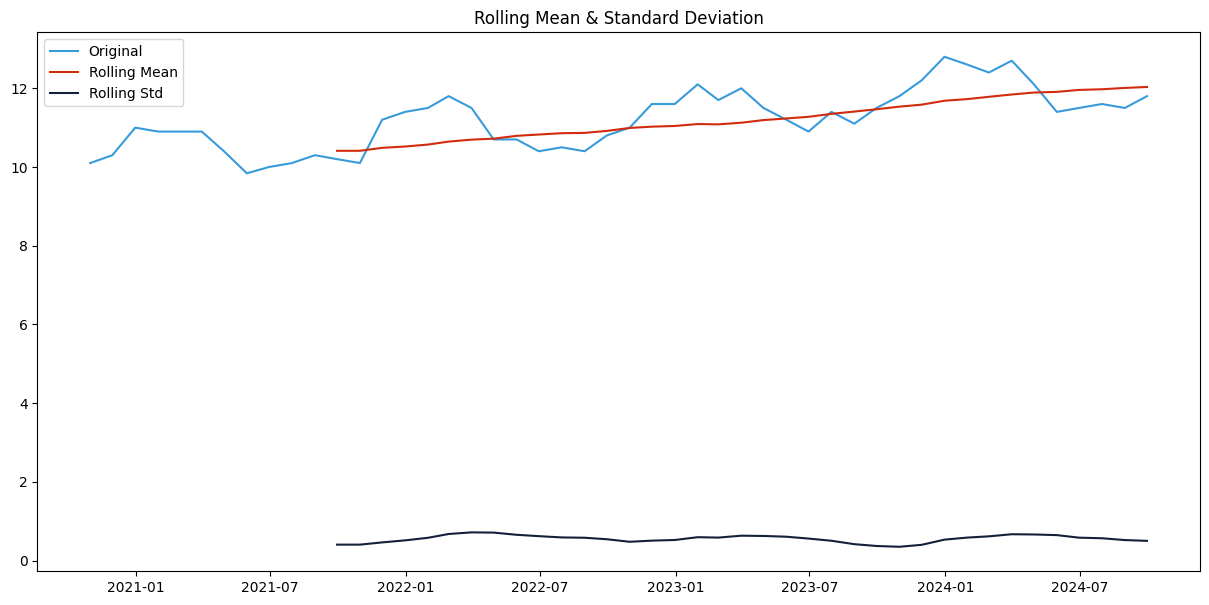

In [3]:
data["rolling_avg"] = data["Prices"].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
data["rolling_std"] = data["Prices"].rolling(window=12).std()

plt.figure(figsize=(15,7))
plt.plot(data["Prices"], color='#379BDB', label='Original')
plt.plot(data["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(data["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

The rolling average helps us see the trend in a data. Here we observe and suspect a small positive linear trend. The rolling standard deviation is pretty much constant which shows that the volatility does not increase with the positive linear trend.

In [4]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(data['Prices'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                  0.218077
p-value                         0.973257
#Lags Used                     10.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64


The **Augmented Dickey-Fuller test** is a statistical test used to determine whether a given time series is stationary or not. Stationarity implies that the statistical properties of a time series, such as its mean and variance, remain constant over time.

To explain the fundemantal parts of the report:

The **test statistic** is a measure of how much evidence there is against the null hypothesis (the hypothesis that the time series is non-stationary). It can be considered like a measure of non-stationarity of the data. In this case, the test statistic is 0.218077.
    
The **p-value** is the probability of observing a test statistic as extreme as, or more extreme than, the one obtained if the null hypothesis were true. A low p-value indicates strong evidence against the null hypothesis. In this case, the p-value is 0.973257, which is quite high so it's highly probable to get a test statistic as high or higher than 0.218077.

The **critical values** are threshold values that are compared to the test statistic to determine whether to reject the null hypothesis. If the test statistic is less than the critical value, you can reject the null hypothesis. In this case, the critical values at the 1%, 5%, and 10% significance levels are -3.620918, -2.943539, and -2.610400, respectively.

To interpret the results of the ADF Test:
Since the test statistic (0.218077) is greater than all of the critical values and the p-value (0.973257) is much higher than the significance level of 0.05 (or 5%), we fail to reject the null hypothesis. This suggests that the time series is non-stationary, meaning it exhibits some form of trend or seasonality.

Hence, based on the Dickey-Fuller Test, our time series is most likely non-stationary.

In [5]:
#Standard ARIMA Model
ARIMA_model = pm.auto_arima(data['Prices'], start_p=1, start_q=1,test='adf', # use adftest to find optimal 'd'
                            max_p=3, max_q=3, # maximum p and q
                            m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                            d=None,# let model determine 'd'
                            seasonal=False, # No Seasonality for standard ARIMA
                            trace=False, #logs 
                            error_action='warn', #shows errors ('ignore' silences these)
                            suppress_warnings=True, stepwise=True)

Even though we suspect the time series to ne non-stationary, we will train a Standard ARIMA model on this non-stationary data and compare certain metrics for this model and the model's results with a Seasonal ARIMA model's metrics and results. This standard model acts as a control group for our analysis to compare our results with.

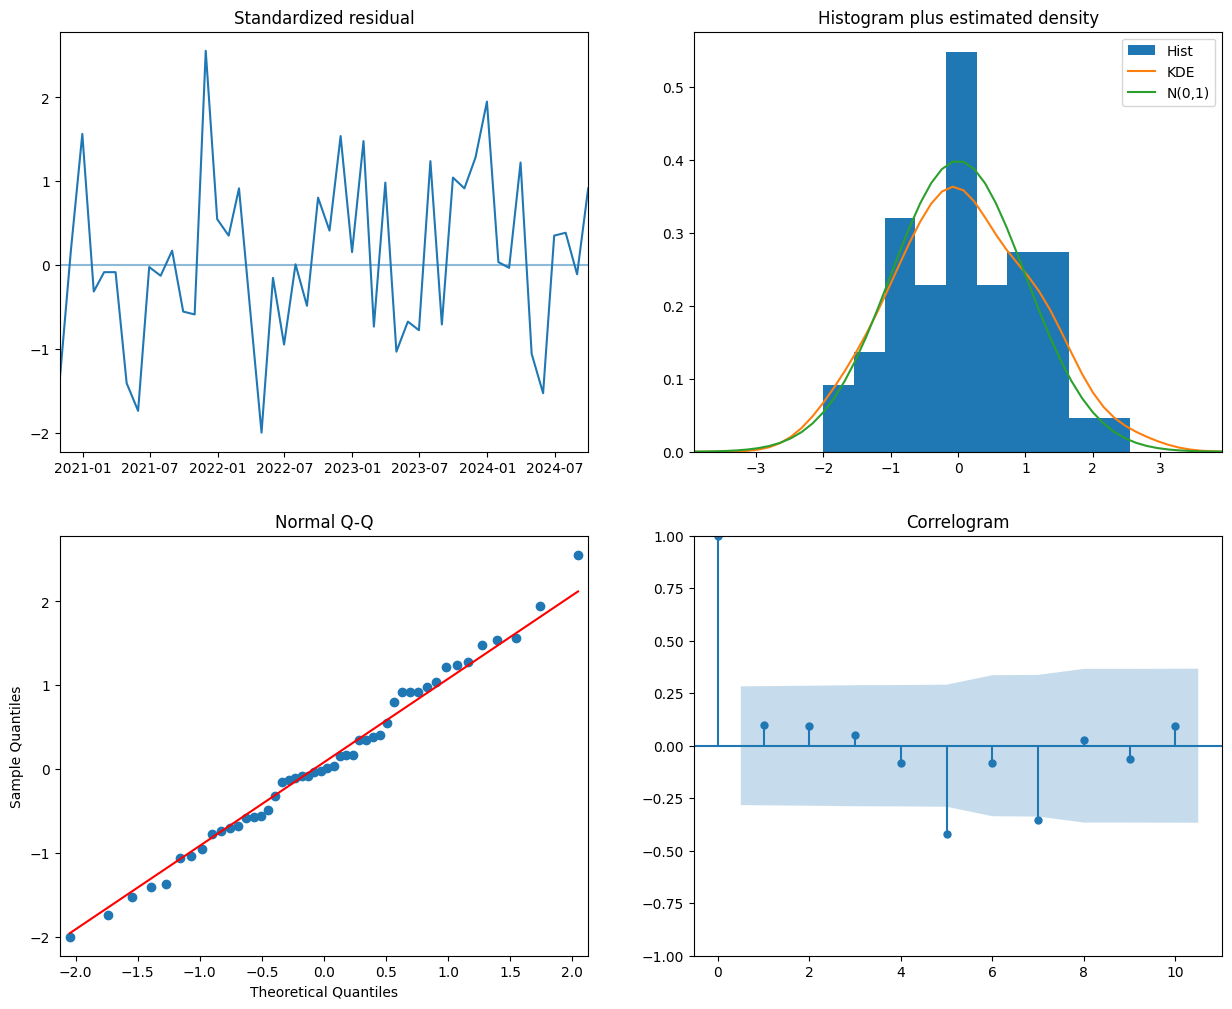

In [6]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

Four plots result from the plot_diagnostics function. The Standardized residual, Histogram plus KDE estimate, Normal q-q, and the correlogram. These are the metrics we can use to compare the standard and seasonal ARIMA model's fit on the time series at hand. How do we know if an ARIMA model is a good fit?
    
**Standardized residual:** There are no obvious patterns in the residuals, with values having a mean of zero and having a uniform variance.
    
**Histogram plus KDE estimate:** The KDE curve should be very similar to the normal distribution (labeled as N(0,1) in the plot).
    
**Normal Q-Q:** Most of the data points should lie on the straight line.
    
**Correlogram/ACF plot:** 95% of correlations for lag greater than zero should not be significant. The grey area is the confidence band, and if values fall outside of this then they are statistically significant. In our case, there are a few values outside of this area, and therefore we may need to add more predictors to make the model more accurate.

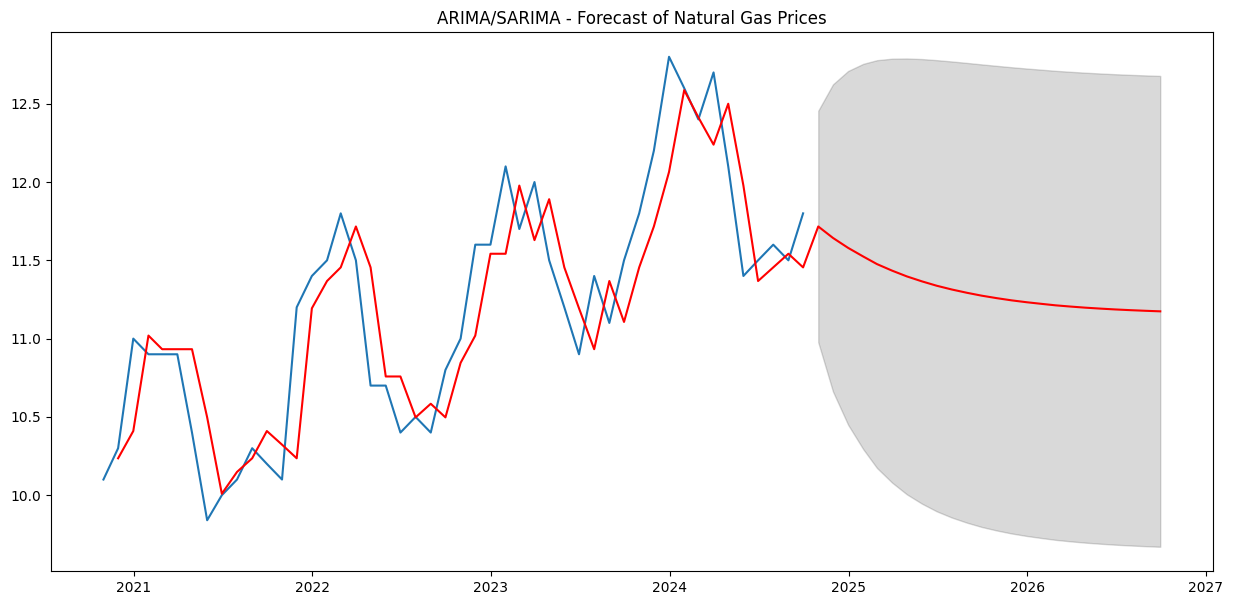

In [7]:
def forecast(ARIMA_model, periods=24):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    fitted_in_sample = ARIMA_model.predict_in_sample(start=1)

    # make series for plotting purpose
    fitted_series = pd.Series(fitted)
    fitted_in_sample_series = pd.Series(fitted_in_sample)
    result = pd.concat([fitted_in_sample_series,fitted_series])
    lower_series = pd.Series(confint[:, 0], index=fitted_series.index)
    upper_series = pd.Series(confint[:, 1], index=fitted_series.index)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(data["Prices"], color='#1f76b4')
    plt.plot(result, color='red')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of Natural Gas Prices")
    plt.show()


forecast(ARIMA_model)

As we can see, the standard ARIMA model does a poor job at predicting the trend and seasonal cycles of the time series. We will compare these results and the model diagnostics with those of a seasonal ARIMA model next.

In [8]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(data["Prices"], start_p=1, start_q=1, test='adf', max_p=3, max_q=3, m=12, #12 is the frequncy of the cycle
                            start_P=0, seasonal=True, #set to seasonal
                            start_Q=0, d=None, D=1, #order of the seasonal differencing
                            trace=False, error_action='ignore', suppress_warnings=True, stepwise=True)

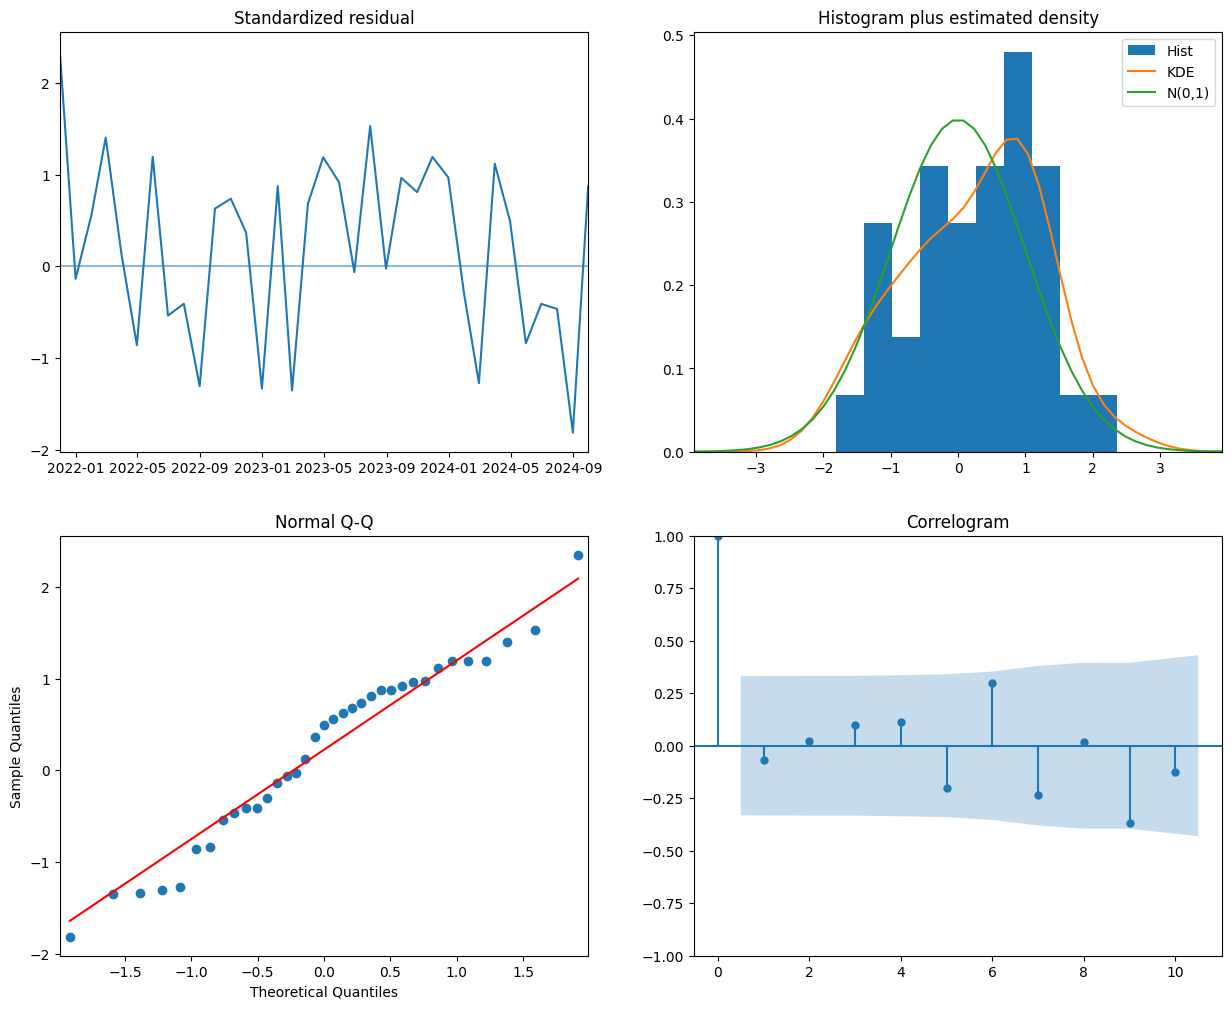

In [9]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

On comparing the model diagnostics of the standard and seasonal ARIMA models, we observe:
    
The standardized residual shows no patterns in both cases so that doesn't help our comparison much. There is a significant difference between the Normal distribution N(0,1) and the KDE curve of the seasonal ARIMA model and the match of the KDE curve and Normal curve is worse than that of a standard ARIMA model. The data points are clustered much closer to the line in the standard ARIMA model than the seasonal ARIMA model in the Normal Q-Q plot. Adding the seasonality component ensured that all values are in the confidence band hence the ACF plot results have improved.

The real results matter more than these diagnostic metrics. So next, we forecast the prices using the SARIMA Model.

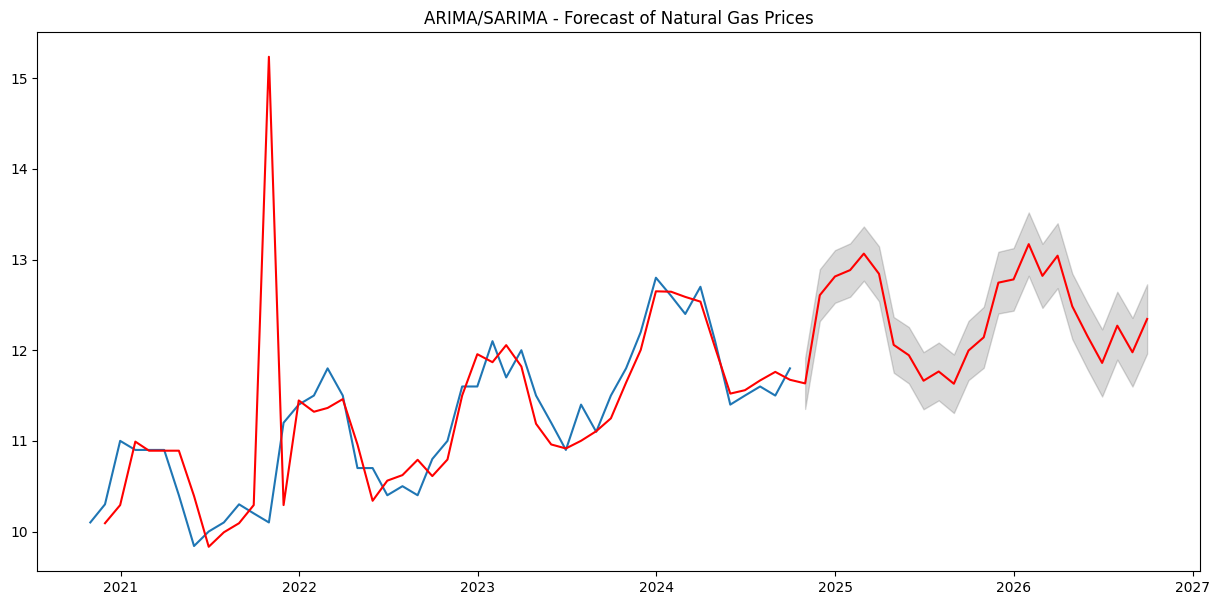

In [10]:
forecast(SARIMA_model)

The results show that adding the seasonal component worked. Our predictions seem much more accurate now and encapsulate the seasonal cycles and the positive linear trend.

Next step is to train a Seasonal ARIMA model with an exogenous variable (called a SARIMAX model) added to it so that we get a more confident prediction (our confidence band width gets smaller).

In [11]:
#adding exogenous variable
data['month_index'] = data.index.month

# SARIMAX Model
SARIMAX_model = pm.auto_arima(data[['Prices']], exogenous=data[['month_index']],
                           start_p=1, start_q=1, test='adf', max_p=3, max_q=3, m=12, start_P=0, seasonal=True, start_Q=0, d=None, D=1, 
                           trace=False, error_action='ignore', suppress_warnings=True, stepwise=True)

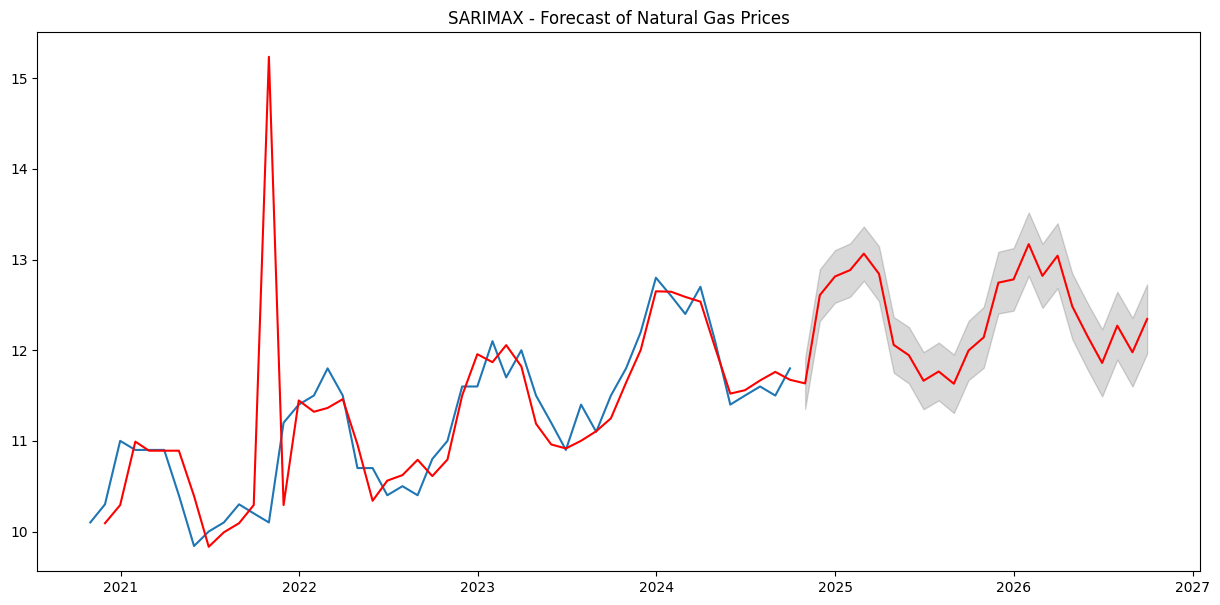

In [12]:
def sarimax_forecast(SARIMAX_model, periods=24):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month_index":pd.date_range(data.index[0], periods = n_periods, freq='MS').month},
                    index = pd.date_range(data.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, return_conf_int=True, exogenous=forecast_df[['month_index']])

    fitted_in_sample = SARIMAX_model.predict_in_sample(start = 1)

    # make series for plotting purpose
    fitted_series = pd.Series(fitted)
    fitted_in_sample_series = pd.Series(fitted_in_sample)
    result = pd.concat([fitted_in_sample_series, fitted_series])
    lower_series = pd.Series(confint[:, 0], index=fitted.index)
    upper_series = pd.Series(confint[:, 1], index=fitted.index)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(data["Prices"], color='#1f76b4')
    plt.plot(result, color='red')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Natural Gas Prices")
    plt.show()

sarimax_forecast(SARIMAX_model, periods=24)

We use just the indices of months as an exogenous variable here since we do not have another exogenous variable. This does not contribute much to the results but it is good to see what it could have done when we actually use an exogneous variable.

In [13]:
def Task_1_Solution(input_date):
    # Solution to TASK 1 of the JPM Quantitative Research Course

    if isinstance(input_date, datetime):
        input_month = input_date.month
        input_year = input_date.year
    elif isinstance(input_date, str):
        try:
            parsed_date = datetime.strptime(input_date, '%Y-%m-%d')
            input_month = parsed_date.month
            input_year = parsed_date.year
        except ValueError:
            print('Invalid date format!')
    else:
        print('Invalid input type!')

    forecasted_values = SARIMA_model.predict(n_periods=12, return_conf_int=False)
    past_estimates_by_model = SARIMA_model.predict_in_sample(start = 1)
    predictions = pd.concat([past_estimates_by_model, forecasted_values])
    predictions.index = predictions.index.to_period('M')
    for prediction_index in predictions.index:
        if prediction_index.year == input_year and prediction_index.month == input_month:
            return predictions[prediction_index]
    

Task_1_Solution("2023-01-09")

11.867954602349792